In [15]:
import json
import pandas as pd
import os

In [186]:
import math
import time
import json
import scipy
import folium
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime, time
import matplotlib.pyplot as plt
from numpy import cos, sin, arcsin, sqrt
%matplotlib inline
plt.figure(figsize=(20,5))
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]
PALETTE_DEG = ["FF"]

<Figure size 1440x360 with 0 Axes>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

### Question 2: Does the traffic intensity at the destination point of a delivery influence the delivery time?

In [19]:
coodinates = json.load(open('drive/MyDrive/ICD-Proyect/Proyect/Traffict/jobs_2345752_results_ICD_STG.json'))

In [20]:
data = coodinates['network']['segmentResults']
tDf = pd.DataFrame(data)

In [21]:
tDf.head()

,segmentId,newSegmentId,speedLimit,frc,streetName,distance,shape,segmentProbeCounts
0,-11520003519799,-0000434c-3100-0400-0000-000000000003,20,7,Calle Condominio Puerta Del Sol,55.66,"[{'latitude': -33.52428, 'longitude': -70.5663...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ..."
1,-11520002385576,-0000434c-3100-0400-0000-000000000004,35,6,Calle Cancha de Carrera,58.35,"[{'latitude': -33.74733, 'longitude': -70.8667...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ..."
2,-11520002879620,-0000434c-3100-0400-0000-000000000005,20,7,Calle Jardín Los Trapenses Dos,38.11,"[{'latitude': -33.33121, 'longitude': -70.5428...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ..."
3,-11520002876227,-0000434c-3100-0400-0000-000000000009,35,6,Calle Los Mostos,52.02,"[{'latitude': -33.48595, 'longitude': -70.5566...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ..."
4,-11520001662072,-0000434c-3100-0400-0000-00000000000a,35,7,NaN,89.93,"[{'latitude': -33.71472, 'longitude': -70.7173...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ..."


In [121]:
def reduceShape(latLonT, keyLat, keyLon):
  if type(latLonT) == list:
    newList = []
    for latLon in latLonT:
      lat = float('{0:.5g}'.format(latLon[keyLat]))
      lon = float('{0:.5g}'.format(latLon[keyLon]))
      newList.append({keyLat: lat , keyLon: lon})
    return newList
  else:
    latLonT = json.loads(latLonT)
    lat = float('{0:.5g}'.format(latLonT[keyLat]))
    lon = float('{0:.5g}'.format(latLonT[keyLon]))
    return {keyLat: lat , keyLon: lon}

In [102]:
tDf['light_shape'] = tDf['shape'].apply(lambda x: reduceShape(x, 'latitude', 'longitude'))
tDfShaped = tDf[:, ['segmentId', 'shape', 'segmentProbeCounts', 'light_shape']]
tDf.head()

,segmentId,shape,segmentProbeCounts,light_shape
0,-11520003519799,"[{'latitude': -33.52428, 'longitude': -70.5663...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ...","[{'latitude': -33.524, 'longitude': -70.566}, ..."
1,-11520002385576,"[{'latitude': -33.74733, 'longitude': -70.8667...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ...","[{'latitude': -33.747, 'longitude': -70.867}, ..."
2,-11520002879620,"[{'latitude': -33.33121, 'longitude': -70.5428...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ...","[{'latitude': -33.331, 'longitude': -70.543}, ..."
3,-11520002876227,"[{'latitude': -33.48595, 'longitude': -70.5566...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ...","[{'latitude': -33.486, 'longitude': -70.557}, ..."
4,-11520001662072,"[{'latitude': -33.71472, 'longitude': -70.7173...","[{'timeSet': 2, 'dateRange': 1, 'probeCount': ...","[{'latitude': -33.715, 'longitude': -70.717}, ..."


In [34]:
tDf.loc[356, 'segmentProbeCounts']

[{'dateRange': 1, 'probeCount': 0, 'timeSet': 2},
 {'dateRange': 1, 'probeCount': 0, 'timeSet': 3},
 {'dateRange': 1, 'probeCount': 0, 'timeSet': 4},
 {'dateRange': 1, 'probeCount': 0, 'timeSet': 5},
 {'dateRange': 1, 'probeCount': 1, 'timeSet': 6},
 {'dateRange': 1, 'probeCount': 1, 'timeSet': 7},
 {'dateRange': 1, 'probeCount': 0, 'timeSet': 8},
 {'dateRange': 1, 'probeCount': 1, 'timeSet': 9}]

In [38]:
coodinates.keys()

dict_keys(['jobName', 'creationTime', 'userPreference', 'dateRanges', 'timeSets', 'network'])

In [40]:
coodinates['dateRanges']

[{'@id': 1,
  'excludedDaysOfWeek': [],
  'exclusions': [],
  'from': '2020-01-01',
  'name': 'January',
  'to': '2020-01-31'}]

In [46]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    start = start.time()
    end = end.time()
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

In [ ]:
timeRangesList = []
initialStrDay = coodinates['dateRanges'][0]['from']
for timeSet in coodinates['timeSets']:
  ranges = timeSet['dayToTimeRanges']
  range = ranges[0]
  fromHour, toHour = range['timeRanges'][0].split('-')
  timeTuple = (
      timeSet['@id'],
      datetime.fromisoformat('{} {}'.format(initialStrDay, fromHour)),
      datetime.fromisoformat('{} {}'.format(initialStrDay, toHour if toHour != "24:00" else "23:59"))
  )
  timeRangesList.append(timeTuple)
timeRangesList[::2]

In [90]:
df = pd.read_pickle('drive/MyDrive/ICD-Proyect/Proyect/data/shippify_icd_new.pkl', compression='gzip')
df = df.dropna(subset=['pickup_effective_dt', 'delivery_effective'])

In [176]:
diff = df['delivery_dt'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

In [122]:
df['light_shape'] = df['delivery_location'].apply(lambda x: reduceShape(x, 'lat', 'lng'))
df.head()

,id,light_shape
0,t-expspa-41,"{'lat': -33.475, 'lng': -70.566}"
1,t-expspa-25,"{'lat': -33.555, 'lng': -70.606}"
2,t-expspa-46,"{'lat': -33.352, 'lng': -70.666}"
4,t-expspa-29,"{'lat': -33.45, 'lng': -70.763}"
5,t-expspa-23,"{'lat': -33.45, 'lng': -70.763}"


In [188]:
def getTraffic(row, trafficDf):
  delivery_effective = row['delivery_effective']
  latLon = row['light_shape']
  lat = latLon['lat']
  lon = latLon['lng']
  sameLatLon = False
  timeSetNo = -1
  traffic = -1
  for _, geoRow  in trafficDf.iterrows():
    trafficsLatLon = geoRow['light_shape']
    probesCounts = geoRow['segmentProbeCounts']
    for trafficLatLon in trafficsLatLon:
      tLat = trafficLatLon['latitude']
      tLon = trafficLatLon['longitude']
      if lat == tLat and lon == tLon:
        sameLatLon = True;
    if sameLatLon:
      for timeRange in timeRangesList:
        if time_in_range(timeRange[1], timeRange[2], delivery_effective):
          timeSetNo = timeRange[0]
    if timeSetNo != -1:
      for segment in probesCounts:
        if segment['timeSet'] == timeSetNo:
          traffic = segment['probeCount']
    
    return traffic

In [145]:
tDfShaped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568016 entries, 0 to 568015
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   segmentId           568016 non-null  int64 
 1   shape               568016 non-null  object
 2   segmentProbeCounts  568016 non-null  object
 3   light_shape         568016 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


In [189]:
dfSample = df.sample(n = 1000)
dfSample['traffic'] = dfSample[['light_shape', 'delivery_effective']].apply(lambda x: getTraffic(x, tDfShaped), axis=1)
dfSample.head()

,id,route_id,creation_date,delivery_type,city,cost,total_size,distance,company_id,company_type,network_id,pickup_dt,pickup_effective_dt,pickuplat,pickuplng,pickup_location,delivery_dt,delivery_effective,lat,long,delivery_location,items,light_shape,delay_delivery,traffic
197719,t-faldis-280658,r-shiinc-273546,2020-06-12 02:18:30+00:00,slot,3,1500.000000,3,23.799999,982,1,286,2020-06-12 13:30:00+00:00,2020-06-12 15:45:30+00:00,-33.527901,-70.706398,"{""lat"":-33.5279,""lng"":-70.7064,""instructions"":...",2020-06-12 14:30:00+00:00,2020-06-12 23:47:07+00:00,-33.411499,-70.566803,"{""lat"":-33.4114577,""lng"":-70.5667916,""instruct...","[{""name"":""144057015421"",""size"":3,""qty"":1,""id"":...","{'lat': -33.411, 'lng': -70.567}",9.285278,0
120879,t-lipisa-31951,r-shiinc-314066,2020-07-30 19:30:21+00:00,slot,3,1352.000000,1,27.700001,4418,1,301,2020-07-31 15:45:00+00:00,2020-07-31 17:23:12+00:00,-33.429001,-70.793297,"{""lat"":-33.4290305,""lng"":-70.7933018,""instruct...",2020-07-31 20:03:37+00:00,2020-07-31 23:14:43+00:00,-33.443802,-70.547203,"{""lat"":-33.4438213,""lng"":-70.5471544,""instruct...","[{""id"":"""",""name"":"""",""size"":1,""qty"":1,""price"":5...","{'lat': -33.444, 'lng': -70.547}",3.185000,1
61433,t-ripace-25265,r-shiinc-298763,2020-07-13 12:11:09+00:00,slot,3,1800.000000,1,8.000000,1985,1,286,2020-07-13 16:00:00+00:00,2020-07-13 15:34:40+00:00,-33.477299,-70.652100,"{""lat"":-33.4773136,""lng"":-70.6521042,""instruct...",2020-07-13 17:34:53+00:00,2020-07-13 17:41:37+00:00,-33.494801,-70.585701,"{""lat"":-33.4947654,""lng"":-70.5856672,""instruct...","[{""name"":""83209186-C"",""size"":1,""qty"":1,""id"":""P...","{'lat': -33.495, 'lng': -70.586}",0.112222,0
191707,t-babuto-78252,r-shiinc-316777,2020-07-31 19:10:56+00:00,slot,3,1511.329956,1,19.600000,162,1,286,2020-08-03 19:00:00+00:00,2020-08-03 19:17:21+00:00,-33.432201,-70.796898,"{""lat"":-33.4322,""lng"":-70.7969,""instructions"":...",2020-08-03 20:00:32+00:00,2020-08-03 21:10:56+00:00,-33.426498,-70.616096,"{""lat"":-33.426506,""lng"":-70.616094,""instructio...","[{""id"":""533796"",""name"":""533796"",""qty"":1,""size""...","{'lat': -33.427, 'lng': -70.616}",1.173333,0
102382,t-womnta-10659,r-shiinc-266753,2020-06-04 23:30:39+00:00,slot,3,2000.000000,3,28.900000,4656,1,286,2020-06-05 15:00:00+00:00,2020-06-05 17:13:22+00:00,-33.301601,-70.709801,"{""lat"":-33.3016,""lng"":-70.7098,""instructions"":...",2020-06-05 16:00:00+00:00,2020-06-05 18:05:31+00:00,-33.525501,-70.633904,"{""lat"":-33.5255061,""lng"":-70.6338471,""instruct...","[{""name"":""19853241"",""size"":3,""qty"":1,""price"":1...","{'lat': -33.526, 'lng': -70.634}",2.091944,0


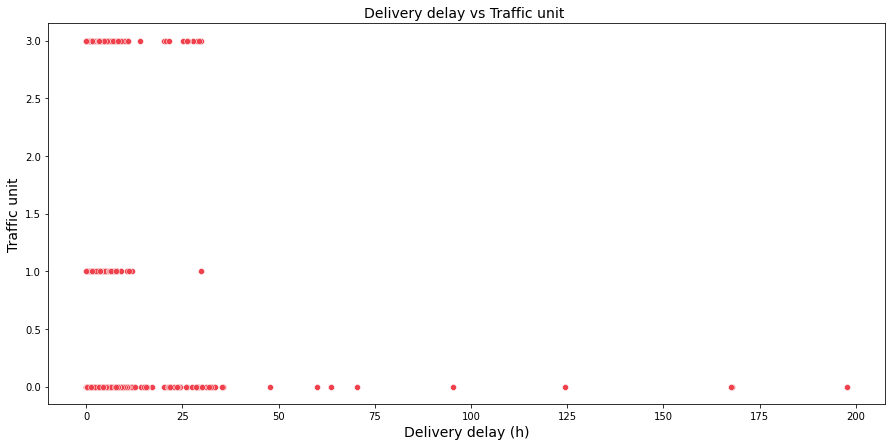

In [190]:
plt.figure(figsize=(15,7))
subdf = dfSample[['traffic','delay_delivery']]
f2 = sns.scatterplot(x=subdf['delay_delivery'], y=subdf['traffic'], color=PALETTE[1])
set_labels(
  title='Delivery delay vs Traffic unit ',
  x_label='Delivery delay (h)', y_label='Traffic unit'
)

In [191]:
subdf.corr()

,traffic,delay_delivery
traffic,1.000000,-0.036527
delay_delivery,-0.036527,1.000000
